In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import optimize, stats
import statsmodels.nonparametric.kernel_regression as nw
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [2]:
########################
# # ejemplo OVERFITTING
########################

### funcion generadora
def f(x):
    z = 2+x**2*np.cos(3*x)/x**(1/10)
    return z

In [3]:
xv = np.linspace(0, 2.5, 100)
yv = f(xv)

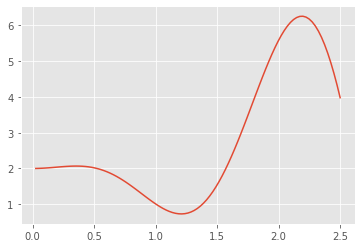

In [4]:
plt.plot(xv, yv)

In [5]:
## Simular datos
N = 400
np.random.seed(123456)
x = np.random.uniform(0, 2.5, N)
x = np.sort(x)
y = np.zeros(N)

In [6]:
for ii in range(0,N):
    y[ii] = f(x[ii]) + np.random.normal(0, 0.8, 1)

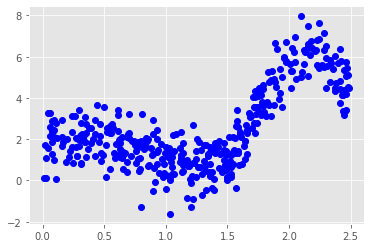

In [7]:
plt.plot(x,y, 'bo')

In [8]:
######
# # seleccionar una muestra
np.random.seed(123456)
samT = np.random.choice(x.shape[0], 200, replace = False)
samT = np.sort(samT)

In [9]:
xT = x[samT] # # X Entrenamientos
yT = y[samT] # # Y Entrenamientos
xTe = x[-samT] # # X Validación
yTe = y[-samT] # # Y Validación

## Nadaraya Wattson

$$\hat{f}(X) = \mathbf{WY}$$

$$\mathbf{W} = \frac{K(\frac{x-x_i}{h})}{\sum_{i}^{n}K(\frac{x-x_i}{h})}$$

$$\sum_{i=1}^{n}W_{hi} = 1$$

In [10]:
# # # Nadaraya Wattson
def W(h):
    L = np.zeros((xT.shape[0], xT.shape[0]))
    for ii in range(xT.shape[0]):
        xx = np.repeat(xT[ii], xT.shape[0])
        den = sum(stats.norm.pdf((xx-xT)/h, 0, 1))
        L[ii] = stats.norm.pdf((xx-xT)/h)/den
    return(L)

In [11]:
def funOver(h):
    y_hat = np.matmul(W(h), yT)
    RMSE = np.sum((yT - y_hat)**2)/yT.shape[0]
    return RMSE

In [12]:
hvals = np.linspace(0.01, 5, 100)
vOver = np.vectorize(funOver)
vOv = vOver(hvals)

In [13]:
vOv

array([0.30687822, 0.57127134, 0.62781293, 0.70505719, 0.81128403,
       0.93712115, 1.07464492, 1.22014382, 1.37071559, 1.52253288,
       1.67152572, 1.8143482 , 1.94874566, 2.07348556, 2.1881292 ,
       2.29278872, 2.38792223, 2.4741797 , 2.55229614, 2.62302284,
       2.6870864 , 2.74516665, 2.79788658, 2.84580958, 2.8894409 ,
       2.92923117, 2.96558106, 2.99884611, 3.0293416 , 3.05734702,
       3.08311021, 3.10685113, 3.12876517, 3.14902609, 3.16778859,
       3.18519064, 3.20135543, 3.21639316, 3.2304025 , 3.24347202,
       3.25568128, 3.26710189, 3.27779843, 3.28782916, 3.29724681,
       3.30609912, 3.3144294 , 3.32227697, 3.32967765, 3.33666403,
       3.34326587, 3.34951036, 3.35542236, 3.36102467, 3.36633818,
       3.3713821 , 3.37617407, 3.38073037, 3.38506597, 3.3891947 ,
       3.39312935, 3.39688174, 3.40046282, 3.40388273, 3.40715089,
       3.41027605, 3.41326634, 3.41612933, 3.41887207, 3.42150114,
       3.42402267, 3.4264424 , 3.42876568, 3.43099753, 3.43314

Text(0.5, 0, 'h')

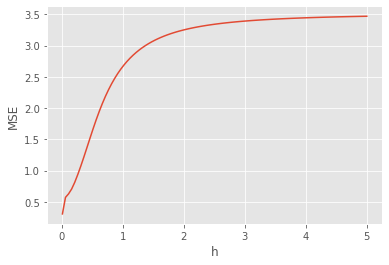

In [15]:
plt.plot(hvals,vOv)
plt.ylabel('MSE')
plt.xlabel('h')

In [16]:
opt_fun = optimize.minimize(funOver, 0.1, method = 'BFGS', options = {'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 36
         Gradient evaluations: 12


In [17]:
opt_fun

      fun: 0.0
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 1
     njev: 12
   status: 0
  success: True
        x: array([-4.3264087e-07])

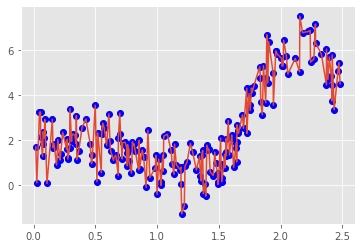

In [18]:
y_hat1 = np.matmul(W(opt_fun['x']), yT)
plt.plot(xT, yT, 'bo')
plt.plot(xT, y_hat1)

In [18]:
#########################
# # CONJUNTOS VALIDACION
#########################

In [19]:
help(nw.KernelReg)

Help on class KernelReg in module statsmodels.nonparametric.kernel_regression:

class KernelReg(statsmodels.nonparametric._kernel_base.GenericKDE)
 |  Nonparametric kernel regression class.
 |  
 |  Calculates the conditional mean ``E[y|X]`` where ``y = g(X) + e``.
 |  Note that the "local constant" type of regression provided here is also
 |  known as Nadaraya-Watson kernel regression; "local linear" is an extension
 |  of that which suffers less from bias issues at the edge of the support. Note
 |  that specifying a custom kernel works only with "local linear" kernel
 |  regression. For example, a custom ``tricube`` kernel yields LOESS regression.
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      This is the dependent variable.
 |  exog : array_like
 |      The training data for the independent variable(s)
 |      Each element in the list is a separate variable
 |  var_type : str
 |      The type of the variables, one character per variable:
 |  
 |          - c: cont

In [20]:
def funMISE(h):
    mod = nw.KernelReg(endog = xT, exog = yT, var_type = 'c', reg_type = 'lc', bw = np.array([h]))
    y_hat = mod.fit(yTe)[0]
    RMSE = sum((yTe - y_hat)**2)/yT.shape[0]
    return RMSE

In [21]:
opt_MISE = optimize.minimize(funMISE, 0.5, method='BFGS', options={'gtol': 1e-6, 'disp': True})
print(opt_MISE)

Optimization terminated successfully.
         Current function value: 4.048072
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 9
      fun: 4.048072080465442
 hess_inv: array([[0.64604527]])
      jac: array([1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.24286423])


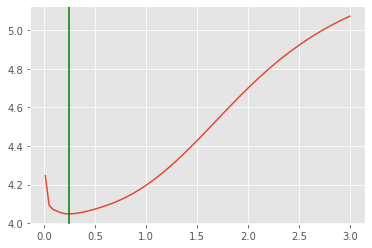

In [23]:
xv2 = np.linspace(0.01, 3, 80)
vMISE = np.vectorize(funMISE)
vMISES = vMISE(xv2)
plt.plot(xv2,vMISES)
plt.axvline(x = opt_MISE['x'], color = 'green')
plt.show()

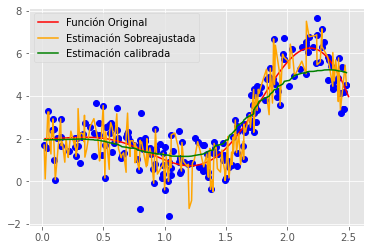

In [24]:
# # # ##############################################
# # # # # ESTIMACION CALIBRADA
# # # ##############################################

# ## Evaluado en el h optimo que minimiza RMSE
y_hat = np.matmul(W(opt_MISE['x']), yTe)
plt.plot(xTe,yTe, 'bo')
plt.plot(xv,yv, color = 'red', label = "Función Original")
plt.plot(xT,y_hat1, color = 'orange', label = "Estimación Sobreajustada")
plt.plot(xTe,y_hat, color = "green", label = "Estimación calibrada")
plt.legend()
plt.show()


# K-Nearest Neighbors

In [ ]:
!pip install scikit-learn

In [25]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor

In [26]:
random.seed(123)
def simData(N):
 x,y =[],[]
 for i in range(N):  
  a = i/10+random.uniform(-1,1)
  yy =math.sin(a)+3+random.uniform(-1,1)
  x.append([a])
  y.append([yy])
  
 return np.array(x), np.array(y)

x,y = simData(400)

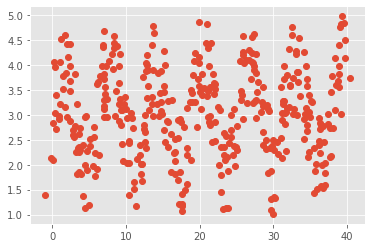

In [31]:
plt.plot(x,y,'o')

In [28]:
y[:6]

array([[1.39399366],
       [2.12998819],
       [2.91907141],
       [3.02825117],
       [3.21241735],
       [2.84114287]])

In [38]:
model = KNeighborsRegressor(n_neighbors=2, p = 2)
print(model)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')


In [39]:
## ajustar el modelo
model.fit(x,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [40]:
# Realizando las predicciones
y_hat = model.predict(x)

In [41]:
## Calcular el error cuadrático medio
mse = mean_squared_error(y, y_hat)
print("El error cuadrático medio es %0.3f:" % mse)

El error cuadrático medio es 0.158:


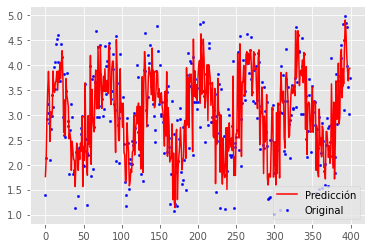

In [42]:
#Graficar las predicciones
x_ax = range(400)
plt.scatter(x_ax, y, s = 5, color = "blue", label = "Original")
plt.plot(x_ax, y_hat, lw = 1.5, color = "red", label = "Predicción")
plt.legend()
plt.show()

### Dividir la base de datos en TRAIN y TEST

In [45]:
######
# # seleccionar una muestra
np.random.seed(123456)
samT = np.random.choice(x.shape[0], 300, replace = False)
samT = np.sort(samT)
xT = x[samT] # # X Entrenamientos
yT = y[samT] # # Y Entrenamientos
xTe = x[-samT] # # X Validación
yTe = y[-samT] # # Y Validación

In [46]:
def funKNN(k, x, y):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(x,y)
    y_hat = model.predict(x)
    mse = mean_squared_error(y, y_hat)
    return mse

In [47]:
mse = []
for ii in np.arange(1,50,1):
    mse.append(funKNN(ii, xT, yT))

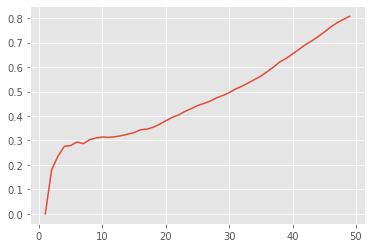

In [48]:
plt.plot(np.arange(1,50,1), mse) ## minimiza en 1 vecino

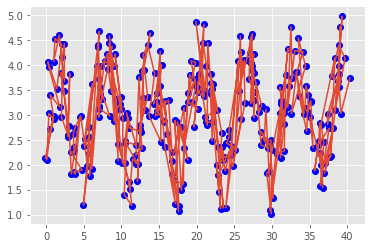

In [49]:
## Estimación inicial
mod0 = KNeighborsRegressor(n_neighbors = 1)
mod0.fit(xT,yT)
y_hat0 = mod0.predict(xT)
mse = mean_squared_error(yT, y_hat0)
plt.plot(xT, yT, 'bo')
plt.plot(xT, y_hat0)

### Estimación calibrada

In [50]:
## entrenar en TRAIN y probar en TEST
def funKNN_cal(k, x, y, xt):
    # k: vecinos
    # x: datos X de entrenamiento
    # y: datos Y de entrenamiento
    # xt: datos X de validación
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(x,y)
    y_hat = model.predict(xt)
    mse = mean_squared_error(y, y_hat)
    return mse

In [51]:
mse = []
for ii in np.arange(1,70,1):
    mse.append(funKNN_cal(ii, xT, yT, xTe))

Text(0, 0.5, 'MSE')

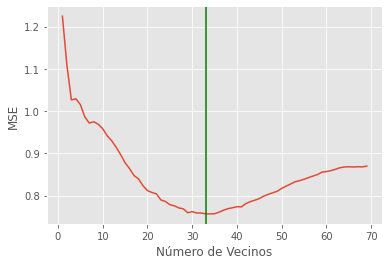

In [52]:
vecinos = np.arange(1,70,1)
plt.plot(np.arange(1,70,1), mse) ## minimiza en 1 vecino
plt.axvline(x = np.argmin(mse), color = 'green')
plt.xlabel('Número de Vecinos')
plt.ylabel('MSE')

## Comprobar

In [54]:
model = KNeighborsRegressor(n_neighbors = np.argmin(mse))
model.fit(xT, yT)
y_hat = model.predict(xTe)
mse = mean_squared_error(yTe, y_hat)

In [55]:
mse

0.5520664892225184

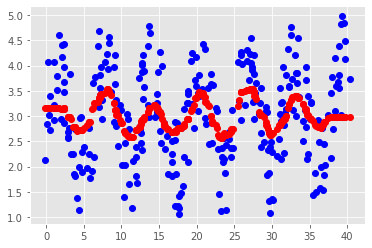

In [56]:
plt.plot(xTe, yTe, 'bo')
plt.plot(xTe, y_hat, 'ro')

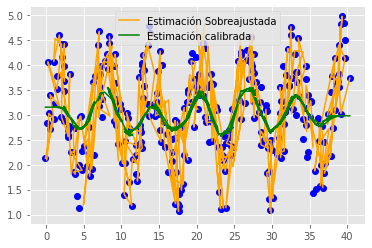

In [137]:
# # # ##############################################
# # # # # ESTIMACION CALIBRADA
# # # ##############################################

# ## Evaluado en el h optimo que minimiza RMSE
plt.plot(xTe, yTe, 'bo')
plt.plot(xT, y_hat0, color = 'orange', label = "Estimación Sobreajustada")
plt.plot(xTe, y_hat, color = "green", label = "Estimación calibrada")
plt.legend()
plt.show()

In [59]:
np.array(xTe).shape

(300, 1)